## New York City Taxi Fare Prediction

## Description

Yellow cabs in NYC are perhaps one of the most recognizable icons in the city. Thoudands of commuters in NYC rely on taxis. In recent years, the taxi industry in NYC has been put under pressure from companies like Uber and Lyft. In order to rise to the challlenge from these companies NYC are looking to modernize thier operations, and to provide a user experience on par with Uber.

In this project I would like to create an algorithm that predicts fare just by taking pickup and dropoff locations.

The dataset for this project can be found on the [New York City Taxi Fare Prediction](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview).
The original dataset contains a massive 55 million trip records from 2009 to 2015, including data such as the pickup and dropoff locations, number of passengers, and pickup datetime. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


## Exploratory data analysis
I am reading the train csv and taking first one million out of 55M. And using parse_dates on pickup_datetime columm so that it is easy to work with time data.

In [2]:
df = pd.read_csv('train.csv', parse_dates = ['pickup_datetime'], nrows = 1000000)

In [3]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


### Data fields

#### ID
* **key** - Unique string identifying each row in both the training and test sets. Comprised of pickup_datetime plus a unique integer, but this doesn't matter, it should just be used as a unique ID field. Required in your submission CSV. Not necessarily needed in the training set, but could be useful to simulate a 'submission file' while doing cross-validation within the training set.


#### Features
* **pickup_datetime**   - timestamp value indicating when the taxi ride started.
* **pickup_longitude**  - float for longitude coordinate of where the taxi ride started.
* **pickup_latitude**   - float for latitude coordinate of where the taxi ride started.
* **dropoff_longitude** - float for longitude coordinate of where the taxi ride ended.
* **dropoff_latitude**  - float for latitude coordinate of where the taxi ride ended.
* **passenger_count**   - integer indicating the number of passengers in the taxi ride.


#### Target
* **fare_amount** - float dollar amount of the cost of the taxi ride. This value is only in the training set; this is what you are predicting in the test set and it is required in your submission CSV.

From the first 5 elements we can see the the table contains a total of 8 columns, of which 'key' seems to be an identifier which is similar to pickup_datetime column so it can be removed. Fare amount is the taget variable which we have to predict using the remaining data. The only data we can use to predict fare are pickup location and drop off location and no. of passengers and time of pickup. 
<br>
First we have to preprocess the data and then analyse.

In [4]:
df = df.drop(['key'],axis = 1)

### Visualizing geolocation data

The pickup and dropoff locations are crucial in predicting fare amount. As fares are mainly dependent on distance travelled.

By plotting pickup and drop off cordinates I would like to find any interesting things in the data.

In [5]:
# range of longitude for NYC
nyc_min_longitude = -74.05
nyc_max_longitude = -73.75

# range of latitude for NYC
nyc_min_latitude = 40.63
nyc_max_latitude = 40.85

df2 = df.copy(deep=True)
for long in ['pickup_longitude', 'dropoff_longitude']:
    df2 = df2[(df2[long] > nyc_min_longitude) & (df2[long] < nyc_max_longitude)]

for lat in ['pickup_latitude', 'dropoff_latitude']:
    df2 = df2[(df2[lat] > nyc_min_latitude) & (df2[lat] < nyc_max_latitude)]

Now, let's plot the pickup locations on a scatterplot. We are also interested in overlaying the scatterplot with a few key landmarks in NYC. A quick Google search tells us that there are two main airports in NYC (JFK and LaGuardia), and their coordinates, along with the main districts in NYC, are as follows:

In [6]:
landmarks = {'JFK Airport': (-73.78, 40.643),
             'Laguardia Airport': (-73.87, 40.77),
             'Midtown': (-73.98, 40.76),
             'Lower Manhattan': (-74.00, 40.72),
             'Upper Manhattan': (-73.94, 40.82),
             'Brooklyn': (-73.95, 40.66)}

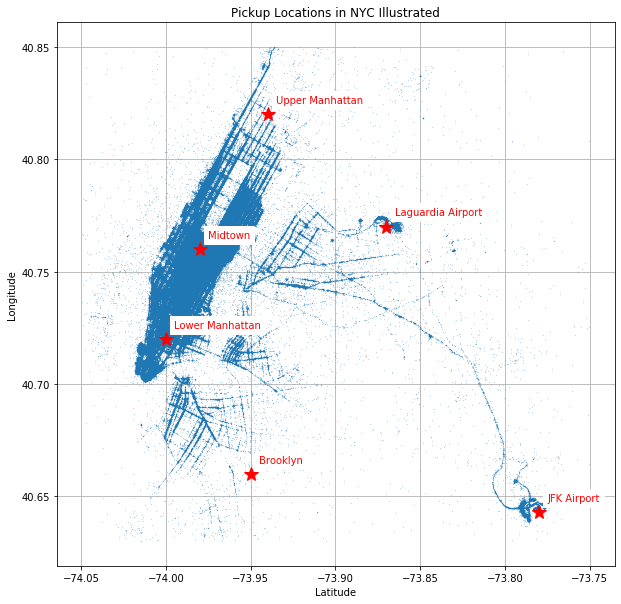

In [7]:
plt.figure(figsize = (10,10)) # set figure size
plt.plot(list(df2.pickup_longitude), list(df2.pickup_latitude), '.', markersize=0.2)
plt.grid(None)
plt.title("Pickup Locations in NYC Illustrated")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
for landmark in landmarks:
        plt.plot(landmarks[landmark][0], landmarks[landmark][1], 
                '*', markersize=15, alpha=1, color='r') 
        plt.annotate(landmark, (landmarks[landmark][0]+0.005, 
                     landmarks[landmark][1]+0.005), color='r', 
                     backgroundcolor='w') 
plt.show()

#### From the preceding scatterplot, we can make a few observations:

* In Manhattan, most pickups were around the Midtown area and Lower Manhattan. In comparison, there are much fewer pickups in Upper Manhattan. 
* Pickups are sparse outside Manhattan. The only two outliers were at LaGuardia Airport and JFK Airport.

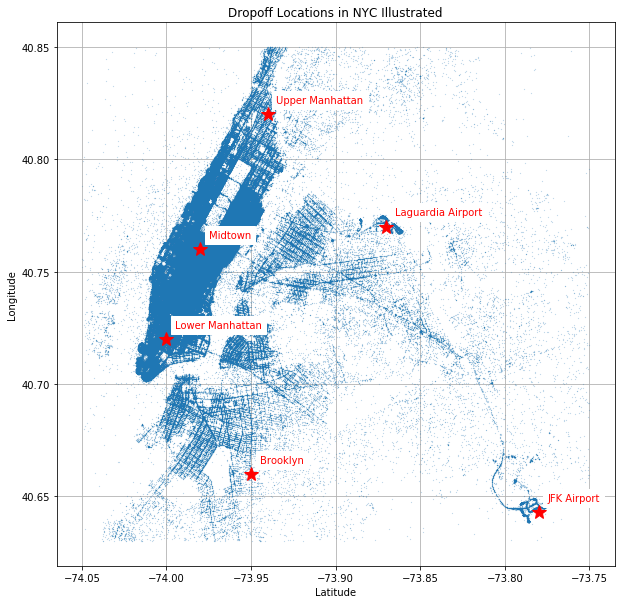

In [8]:
plt.figure(figsize = (10,10)) # set figure size
plt.plot(list(df2.dropoff_longitude), list(df2.dropoff_latitude), '.', markersize=0.2)
plt.grid(None)
plt.title("Dropoff Locations in NYC Illustrated")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
for landmark in landmarks:
        plt.plot(landmarks[landmark][0], landmarks[landmark][1], 
                '*', markersize=15, alpha=1, color='r') 
        plt.annotate(landmark, (landmarks[landmark][0]+0.005, 
                     landmarks[landmark][1]+0.005), color='r', 
                     backgroundcolor='w') 
plt.show()

Comparing the pickup and drop off scatterplots, we can clearly see that there are more drop offs than pickups in areas such as Upper Manhattan and Brooklyn. Other area's data looks similar.

## Data Preprocessing

In this section, I will expolore the data and find any relations between features. Main aspect of this section is to clean the data i.e., find if any feature has missing values or any outliers and remove them.

### Handling missing vlues and data anomalies

Trying to find if the data contains any missing values in it.

In [9]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1000000.000000,1000000.000000,1000000.000000,999990.000000,999990.000000,1000000.000000
mean,11.348079,-72.526640,39.929008,-72.527860,39.919954,1.684924
std,9.822090,12.057937,7.626154,11.324494,8.201418,1.323911
min,-44.900000,-3377.680935,-3116.285383,-3383.296608,-3114.338567,0.000000
25%,6.000000,-73.992060,40.734965,-73.991385,40.734046,1.000000
50%,8.500000,-73.981792,40.752695,-73.980135,40.753166,1.000000
75%,12.500000,-73.967094,40.767154,-73.963654,40.768129,2.000000
max,500.000000,2522.271325,2621.628430,45.581619,1651.553433,208.000000


From the above data we can see that dropoff latitude and longitude have some missing values.<br>
And also we can see that fareamount is negative, passenger count is 0 in some cases and 208 is the max value (whaaat??).
<br>
Latitude and longitude values are off limits.
<br>
We have to clear these discrepancies.

In [10]:
df.isnull().sum()

fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    10
dropoff_latitude     10
passenger_count       0
dtype: int64

We can see that that there are 10 cases where the data is missing. 10 values are very small when compared to a data of 1M. So dropping them is insignificant.

In [11]:
df = df.dropna()

### Exploring  fare amount feature
Now we have to analyse the fareamount first. We can do that by plotting a histogram

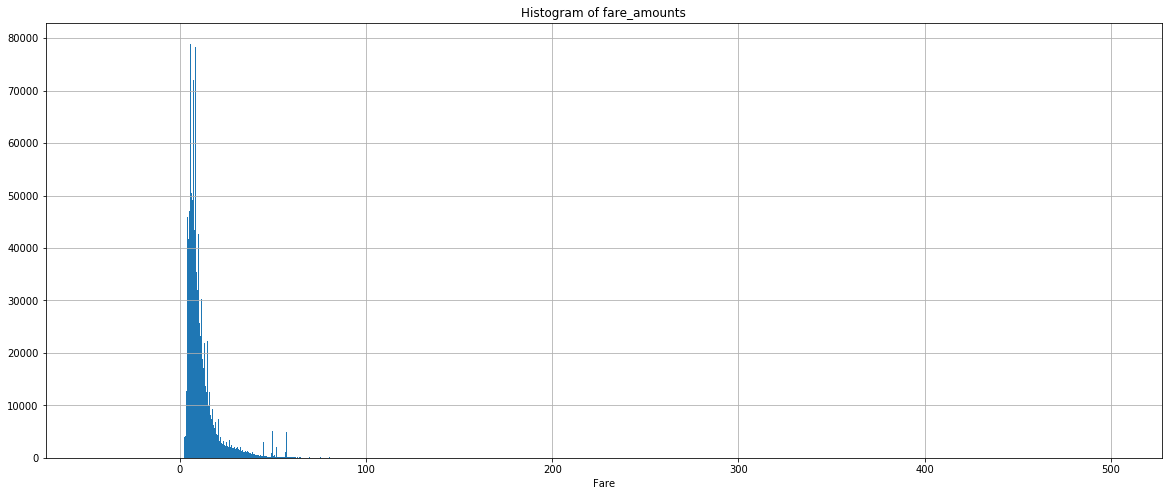

In [12]:
df['fare_amount'].hist(bins = 1000, figsize = (20,8))
plt.xlabel('Fare')
plt.title('Histogram of fare_amounts')
plt.show()


From the graph we can clearly see that there are outliers in the data. And the fares are even negative. We can also see that the fares maxed out at 500 which is definitely an outlier. We have to restrict the fare to 100 usd so that we can remove the outliers. And also from the website we can see that the min_fare starts at 2.5usd.
<br>
From the graph we can also see that there are few peaks around 50 dollars mark. This is because the fares are fixed from few locations(Airports).

In [13]:
df = df[df['fare_amount']>2.50]

In [14]:
df = df[df['fare_amount']<=100]

In [15]:
df.shape

(995514, 7)

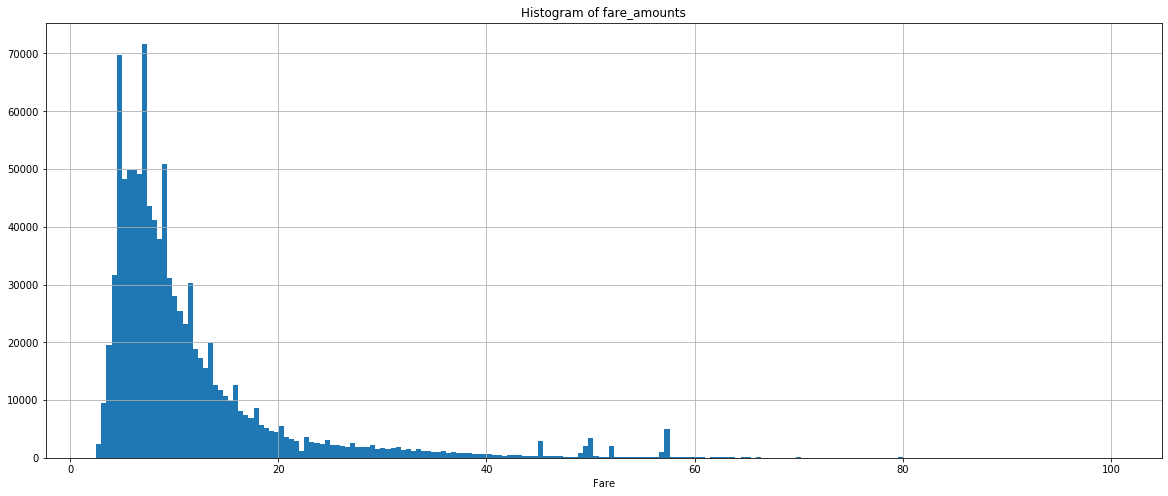

In [16]:
df['fare_amount'].hist(bins = 200, figsize = (20,8))
plt.xlabel('Fare')
plt.title('Histogram of fare_amounts')
plt.show()

### Exploring passenger_count feature

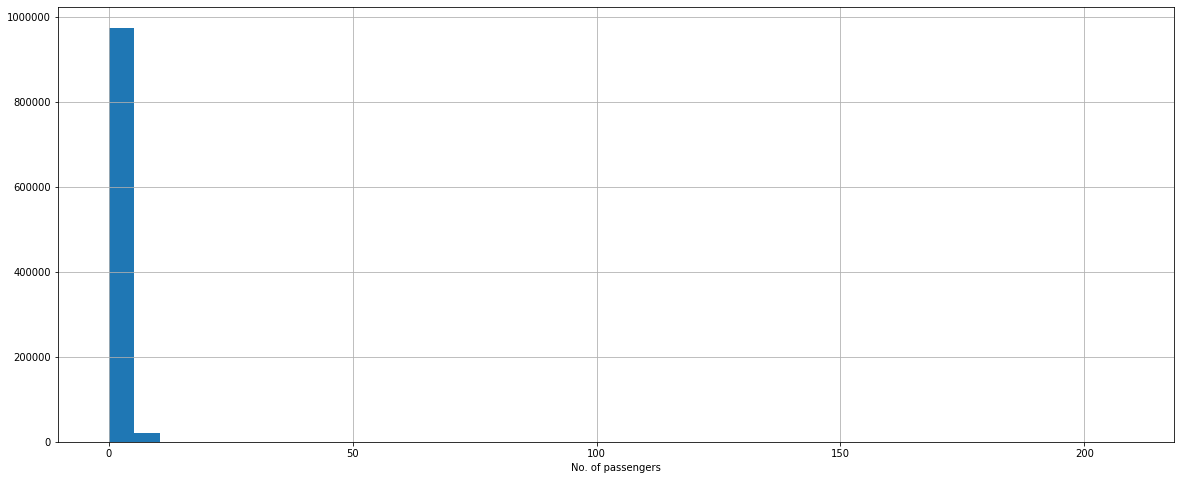

In [17]:
df['passenger_count'].hist(bins = 40, figsize = (20,8))
plt.xlabel('No. of passengers')
plt.show()

From the graph we can see that the passenger count definitely contains outliers. From the website we can see that there is a max of 6 passengers limit. So we have to remove the rest of the data.

In [18]:
df = df[df['passenger_count'] <=10]

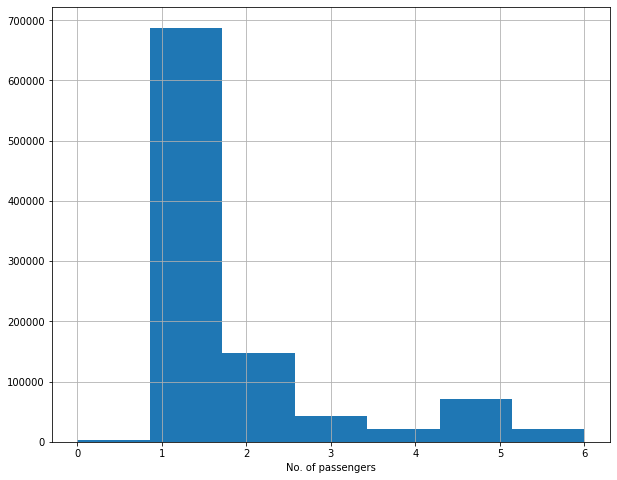

In [19]:
df['passenger_count'].hist(bins = 7, figsize = (10,8))
plt.xlabel('No. of passengers')
plt.show()

We can see that few rides have passenger count of 0. I want to replace these data with mode as we have already discarded many values.

In [20]:
df.loc[df['passenger_count'] == 0, 'passenger_count'] = 1

### Exploring the pickup coordinate values

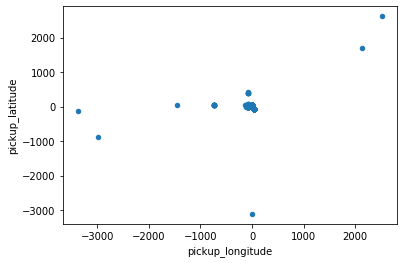

In [21]:
df.plot.scatter('pickup_longitude', 'pickup_latitude')
plt.show()

From the above plot we can see that there are many outliers. Those are not even in the range of actual coordinate system. From the google maps we can see that the NYC have values ranging between (-74.11, -73.70) Longitude and (40.50, 40.92) Latitude.

In [22]:
for long in ['pickup_longitude', 'dropoff_longitude']:
    df = df[(df[long] >= -74.11) & (df[long] <= -73.70) ]
for lat in ['pickup_latitude', 'dropoff_latitude']:
    df = df[(df[lat]>=40.5) & (df[lat] <= 40.92)]

In [23]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,972617.000000,972617.000000,972617.000000,972617.000000,972617.000000,972617.000000
mean,11.214002,-73.975499,40.750915,-73.974295,40.751344,1.689429
std,9.021986,0.034087,0.026737,0.032740,0.030554,1.305081
min,2.510000,-74.109605,40.503982,-74.109897,40.503503,1.000000
25%,6.000000,-73.992265,40.736614,-73.991526,40.735763,1.000000
50%,8.500000,-73.982092,40.753422,-73.980575,40.753927,1.000000
75%,12.500000,-73.968383,40.767570,-73.965393,40.768420,2.000000
max,100.000000,-73.700438,40.919277,-73.700155,40.919865,6.000000


We've finally cleaned the data and made sure there are no missing values or outliers. Now, we have to analyse the datetime column

## Feature Engineering

In this section, I create features based on the date and time of pickup, and location-related features.

**Temporal Features**

In [24]:
df['pickup_datetime'].head()

0   2009-06-15 17:26:21+00:00
1   2010-01-05 16:52:16+00:00
2   2011-08-18 00:35:00+00:00
3   2012-04-21 04:30:42+00:00
4   2010-03-09 07:51:00+00:00
Name: pickup_datetime, dtype: datetime64[ns, UTC]

We cannot feed the data in this format to a neural network. We can only input numerical data. So we have to change this data. 

In [25]:
df['year'] = df['pickup_datetime'].dt.year
df['month'] = df['pickup_datetime'].dt.month
df['day'] = df['pickup_datetime'].dt.day
df['dow'] = df['pickup_datetime'].dt.dayofweek
df['hour'] = df['pickup_datetime'].dt.hour

In [26]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,dow,hour
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,0,17
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,1,16
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,3,0
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,5,4
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,1,7


Now we can drop the pickup_datetime column as the data in it is safely replicated into other new columns.

In [27]:
df = df.drop(['pickup_datetime'],axis = 1)

**Geolocation features**

One feature that is important in determining the fare is the distance between the pickup and dropoff locations. But we are not given this information. However we know the coordinated of two locations. We can create a new feature with the help of these.

In [28]:
def dist(pic_lat, pic_long, drop_lat, drop_lang):
    return (((pic_lat-drop_lat)**2+(pic_long-drop_lang)**2)**0.5)

In [29]:
df['distance'] = dist(df['pickup_latitude'],df['pickup_longitude'],df['dropoff_latitude'],df['dropoff_longitude'])

In [30]:
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,dow,hour,distance
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,0,17,0.009436
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,1,16,0.079696
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,3,0,0.013674
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,5,4,0.025340
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,1,7,0.019470


Let us see if there is any relation between the distance and fare

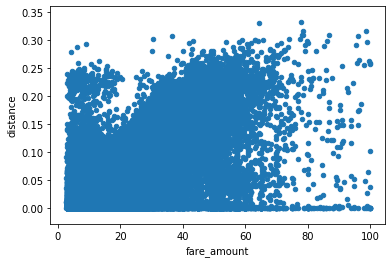

In [31]:
df.plot.scatter('fare_amount','distance')
plt.show()

From the graph we can see that there is realtion between the fare and distance. And also we see there are constant fares around 50$. We already known that there are seperate fares from airport and to airports which are fixed. So we have to add few more columns for these specifically.

In [32]:
airports = {'JFK' : (40.641311, -73.778225), "LaGuardia" : (40.776951, -73.874062), 'Newark' : (40.689458, -74.174677)}

for ap in airports:
    df['pickup_' + ap] = dist(df['pickup_latitude'],df['pickup_longitude'],airports[ap][0],airports[ap][1])
    df['dropoff_' + ap] = dist(df['dropoff_latitude'],df['dropoff_longitude'],airports[ap][0],airports[ap][1])

In [33]:
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,dow,hour,distance,pickup_JFK,dropoff_JFK,pickup_LaGuardia,dropoff_LaGuardia,pickup_Newark,dropoff_Newark
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,0,17,0.009436,0.103772,0.095152,0.063088,0.072358,0.331899,0.333848
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,1,16,0.079696,0.247909,0.245383,0.156428,0.105327,0.160126,0.216216
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,3,0,0.013674,0.237099,0.239399,0.109801,0.120115,0.204933,0.193345
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,5,4,0.025340,0.228198,0.243213,0.121258,0.119009,0.192568,0.195550
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,1,7,0.019470,0.228260,0.228319,0.094457,0.082873,0.221012,0.237543


## Feature Scaling

There is one more step, the final one to be done. We have to scale the data so that no feature dominates the outcome of the network.

In [34]:
df_prescaled = df.copy()

In [35]:
df_scaled = df.drop(['fare_amount'], axis = 1)
cols = df_scaled.columns.tolist()

In [36]:
df_scaled.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,dow,hour,distance,pickup_JFK,dropoff_JFK,pickup_LaGuardia,dropoff_LaGuardia,pickup_Newark,dropoff_Newark
0,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,0,17,0.009436,0.103772,0.095152,0.063088,0.072358,0.331899,0.333848
1,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,1,16,0.079696,0.247909,0.245383,0.156428,0.105327,0.160126,0.216216
2,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,3,0,0.013674,0.237099,0.239399,0.109801,0.120115,0.204933,0.193345
3,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,5,4,0.025340,0.228198,0.243213,0.121258,0.119009,0.192568,0.195550
4,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,1,7,0.019470,0.228260,0.228319,0.094457,0.082873,0.221012,0.237543


In [37]:
df_scaled = scale(df_scaled);

In [38]:
df_scaled = pd.DataFrame(df_scaled, columns = cols, index = df.index)
df_scaled = pd.concat([df_scaled, df['fare_amount']], axis = 1)

In [39]:
df = df_scaled.copy()

In [40]:
df_scaled.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,dow,hour,distance,pickup_JFK,dropoff_JFK,pickup_LaGuardia,dropoff_LaGuardia,pickup_Newark,dropoff_Newark,fare_amount
0,3.848603,-1.106919,4.052663,-1.278572,-0.528265,-1.471449,-0.078136,-0.079583,-1.559053,0.535080,-0.648467,-3.875803,-4.607018,-1.845947,-1.439231,3.421542,3.472695,4.5
1,-1.189581,-1.481531,-0.151886,1.003473,-0.528265,-0.934599,-1.532413,-1.231221,-1.046154,0.381524,1.229688,0.636878,0.624646,1.796138,-0.168621,-1.395586,0.132868,16.9
2,-0.212378,0.387299,-0.517613,-0.025585,0.237971,-0.397749,0.503575,0.265909,-0.020355,-2.075376,-0.535173,0.298435,0.416269,-0.023197,0.401278,-0.139037,-0.516510,5.7
3,-0.341224,-0.664687,-0.527539,0.220863,-0.528265,0.139101,-0.659847,0.611400,1.005444,-1.461151,-0.223311,0.019778,0.549081,0.423831,0.358658,-0.485810,-0.453884,7.7
4,0.217198,0.639309,0.538793,1.061010,-0.528265,-0.934599,-0.950702,-0.770566,-1.046154,-1.000482,-0.380251,0.021722,0.030405,-0.621918,-1.033986,0.311870,0.738394,5.3


## Building a model 

First, we have to split the data into data and class.

In [41]:
X = df.loc[:, df.columns != 'fare_amount']
y = df.loc[:, 'fare_amount']

Splitting the data into training and testing sets.

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

Building a model in Keras 

In [43]:
model = Sequential()
model.add(Dense(256, activation = 'relu', input_dim = X_train.shape[1]))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
# model.add(Dense(128, activation = 'relu'))
# model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(8, activation = 'relu'))
model.add(Dense(4, activation = 'relu'))
model.add(Dense(2, activation = 'relu'))
model.add(Dense(1))

In [44]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               4608      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 36        
__________

Finally, we compile and train our neural network on the training data.

In [45]:
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mse'])
model.fit(X_train, y_train, epochs = 100)





Epoch 1/100





778093/778093 [==============================] - 119s 152us/step - loss: 13.8818 - mean_squared_error: 13.8818
Epoch 2/100
778093/778093 [==============================] - 114s 147us/step - loss: 12.0635 - mean_squared_error: 12.0635
Epoch 3/100
778093/778093 [==============================] - 115s 148us/step - loss: 11.5427 - mean_squared_error: 11.5427
Epoch 4/100
778093/778093 [==============================] - 115s 148us/step - loss: 11.3444 - mean_squared_error: 11.3444
Epoch 5/100
778093/778093 [==============================] - 475s 611us/step - loss: 11.2075 - mean_squared_error: 11.2075
Epoch 6/100
778093/778093 [==============================] - 120s 154us/step - loss: 11.1162 - mean_squared_error: 11.1162
Epoch 7/100
778093/778093 [==============================] - 117s 151us/step - loss: 10.9936 - mean_squared_error: 10.9936
Epoch 8/100
778093/778093 [==============================] - 114s 147us/step - loss: 10.9487 - mean_squared_error: 10.9487
Epoch 9

778093/778093 [==============================] - 115s 148us/step - loss: 9.7962 - mean_squared_error: 9.7962
Epoch 53/100
778093/778093 [==============================] - 115s 148us/step - loss: 9.7654 - mean_squared_error: 9.7654
Epoch 54/100
778093/778093 [==============================] - 115s 148us/step - loss: 9.7497 - mean_squared_error: 9.7497
Epoch 55/100
778093/778093 [==============================] - 115s 148us/step - loss: 9.7755 - mean_squared_error: 9.7755
Epoch 56/100
778093/778093 [==============================] - 115s 148us/step - loss: 9.7421 - mean_squared_error: 9.7421
Epoch 57/100
778093/778093 [==============================] - 115s 147us/step - loss: 9.7243 - mean_squared_error: 9.7243
Epoch 58/100
778093/778093 [==============================] - 115s 148us/step - loss: 9.7349 - mean_squared_error: 9.7349
Epoch 59/100
778093/778093 [==============================] - 115s 148us/step - loss: 9.7021 - mean_squared_error: 9.7021
Epoch 60/100
778093/778093 [=========

In [46]:
def predict_random(df_prescaled, X_test, model):
        sample = X_test.sample(n=1, random_state=np.random.randint(low=0, high=10000))
        idx = sample.index[0]
        actual_fare = df_prescaled.loc[idx,'fare_amount']
        day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        day_of_week = day_names[df_prescaled.loc[idx,'dow']]
        hour = df_prescaled.loc[idx,'hour']
        predicted_fare = model.predict(sample)[0][0]
        rmse = np.sqrt(np.square(predicted_fare-actual_fare))

        print("Trip Details: {}, {}:00hrs".format(day_of_week, hour)) 
        print("Actual fare: ${:0.2f}".format(actual_fare))
        print("Predicted fare: ${:0.2f}".format(predicted_fare))
        print("RMSE: ${:0.2f}".format(rmse))


In [47]:
import numpy as np

In [48]:
predict_random(df_prescaled, X_test, model)

Trip Details: Friday, 9:00hrs
Actual fare: $7.50
Predicted fare: $8.24
RMSE: $0.74


In [49]:
from sklearn.metrics import mean_squared_error

train_pred = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))

test_pred = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

print("Train RMSE: {:0.2f}".format(train_rmse))
print("Test RMSE: {:0.2f}".format(test_rmse))



Train RMSE: 3.07
Test RMSE: 3.24
